### This notebook show how the dataset is built, and how the model is trained. But only a subset of the data is shared on the repo, so the performances will not be optimal. Prefer to use `1_train_MLP.py` which uses `X_train_full.pt`

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

sys.path.append(os.path.abspath(".."))

import matplotlib.pyplot as plt
import numpy as np
import torch 

from scr.ts_utils import create_dataset_with_stft, harmonic_stacking
from scr.display import midi_to_image

np.random.seed(42)

# 1. Creating the dataset using the mp3 and mid files

In [3]:
def load_data_from_folder(folder, sample_rate, duration, ticks_per_beat, bpm, overlap_ratio, freq_resolution):
    """
    Given a folder with audio and MIDI files, this function will load the data
    into X and y arrays, split them into train and test sets (80% train, 20% test).
    """
    
    # List all .wav and .mid files in the folder
    mp3_files = [f for f in os.listdir(folder) if f.endswith('.wav')]
    midi_files = [f for f in os.listdir(folder) if f.endswith('.mid')]

    # Shuffle the list of files to ensure random splitting
    np.random.shuffle(midi_files)

    num_train = int(0.8 * len(midi_files))
    train_files = midi_files[:num_train]
    test_files = midi_files[num_train:]

    print("Training songs : "+", ".join([x[:-4] for x in train_files]))
    print("Testing songs : "+", ".join([x[:-4] for x in test_files]))
    
    # Initialize lists to store the training and testing data
    X_train, y_train = [], []
    X_test, y_test = [], []

    # Load training data
    for midi_file in train_files:
        for mp3_file in mp3_files:
            if midi_file[:-4] in mp3_file.split("_shift")[0]:
                shift = int(mp3_file.split("_shift_")[1][:-4])
                mp3_path = os.path.join(folder, mp3_file)
                midi_path = os.path.join(folder, midi_file)
                
                X, y = create_dataset_with_stft(mp3_path, midi_path, shift, sample_rate, duration,
                                            ticks_per_beat=ticks_per_beat, bpm=bpm,
                                            overlap_ratio=overlap_ratio, freq_resolution=freq_resolution)
                X_train.append(X)
                y_train.append(y)

    # Load testing data
    for midi_file in test_files:
        for mp3_file in mp3_files:
            if midi_file[:-4] in mp3_file.split("_shift")[0]:
                shift = int(mp3_file.split("_shift_")[1][:-4])
                mp3_path = os.path.join(folder, mp3_file)
                midi_path = os.path.join(folder, midi_file)
                
                X, y = create_dataset_with_stft(mp3_path, midi_path, shift, sample_rate, duration,
                                            ticks_per_beat=ticks_per_beat, bpm=bpm,
                                            overlap_ratio=overlap_ratio, freq_resolution=freq_resolution)
                X_test.append(X)
                y_test.append(y)


    # Convert lists to numpy arrays or torch tensors (depending on your needs)
    X_train = np.concatenate(X_train, axis=0)  # Assuming the outputs are numpy arrays
    y_train = np.concatenate(y_train, axis=0)
    X_test = np.concatenate(X_test, axis=0)
    y_test = np.concatenate(y_test, axis=0)

    return X_train, y_train, X_test, y_test, len(train_files), len(test_files)


# Example usage:

folder_path = '../data/simple_piano_dataset_extract'
sample_rate = 22050
duration = None
ticks_per_beat = 4
bpm = 120
overlap_ratio = 0.5
freq_resolution = 2


X_train, y_train, X_test, y_test, n_train, n_test = load_data_from_folder(
    folder_path, sample_rate, duration, ticks_per_beat, bpm, overlap_ratio, freq_resolution
)

X_train, y_train, X_test, y_test = torch.Tensor(X_train), torch.Tensor(y_train), torch.Tensor(X_test), torch.Tensor(y_test)

X_train = X_train[:, None, :, None]
X_test = X_test[:, None, :, None]

CONTOURS_BINS_PER_SEMITONE = 3
ANNOTATIONS_N_SEMITONES = 88  # number of piano keys
N_FREQ_BINS_CONTOURS = ANNOTATIONS_N_SEMITONES * CONTOURS_BINS_PER_SEMITONE

X_train = harmonic_stacking(
    X_train,
    list(range(-3, 4)),
    N_FREQ_BINS_CONTOURS,
)
X_test = harmonic_stacking(
    X_test,
    list(range(-3, 4)),
    N_FREQ_BINS_CONTOURS,
)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


Training songs : we-three-kings-christmas, there-goes-my-everything, anniversary-song, super-mario-underwater, lo-mucho-que-te-amo, blue-danube-waltz-strauss, bagatella, yesterday-the-beatles, its-a-small-world-disney, star-wars
Testing songs : through-the-enchanted-forrest, cuckoo-suzuki, lullaby-brahms
X_train shape: torch.Size([9141, 1, 88, 7]), y_train shape: torch.Size([9141, 88])
X_test shape: torch.Size([2208, 1, 88, 7]), y_test shape: torch.Size([2208, 88])


In [4]:
mean, std = X_train.mean(dim=(0, 1)), X_train.std(dim=(0, 1))
std[std == 0] = 1
X_train = (X_train - mean)/std
X_test = (X_test - mean)/std


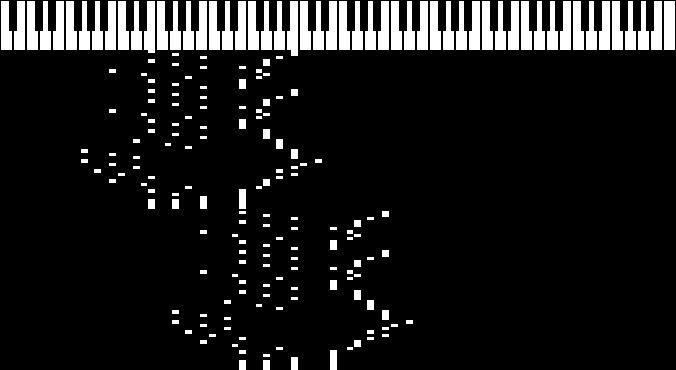

In [5]:
midi_to_image(y_train.numpy(), ticks_per_beat, bpm, duration=40, with_keybord=True)

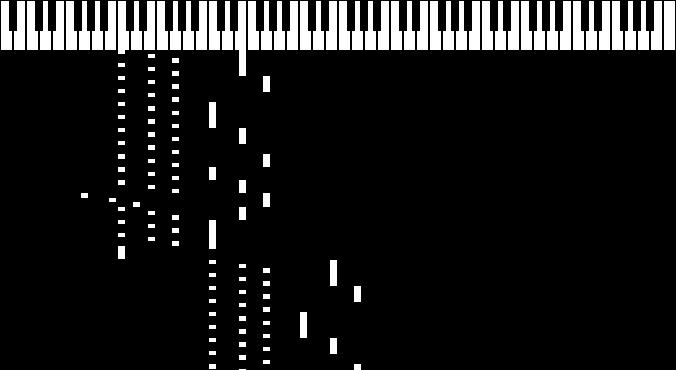

In [6]:
midi_to_image(y_test.numpy(), ticks_per_beat, bpm, duration=40, with_keybord=True)

# 2. Model : CNN + rolling window to add temporal information

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
import json


def roll(X, roll_depth=0):
    if roll_depth > 0:
        X_roll = np.zeros((X.shape[0], 1+2*roll_depth, X.shape[2], X.shape[3]))
        for i in range(X.shape[0]):
            # Determine start and end indices for rolling window
            start = max(0, i - roll_depth)
            end = min(X.shape[0], i + roll_depth + 1)
            
            # Calculate offset in the rolled array
            offset_start = max(0, roll_depth - i)
            offset_end = offset_start + (end - start)
            
            # Copy the relevant slice
            X_roll[i, offset_start:offset_end, :, :] = X[start:end, 0, :, :]
        return X_roll
    else:
        return X
    
class CNNModel(nn.Module):
    def __init__(self, roll_depth, input_shape):
        super(CNNModel, self).__init__()
        self.input_shape = input_shape
        self.roll_depth = roll_depth
        # Define convolutional layers
        self.conv_layers = nn.ModuleList([
            nn.Conv2d(1+2*roll_depth, 64, kernel_size=3, stride=1, padding=2),  # Input channels: 1, Output channels: 16
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), # Input channels: 16, Output channels: 32
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),  # Input channels: 32, Output channels: 64
        ])

        self.flattened_size = self._compute_flattened_size()
        
        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(self.flattened_size, 128),  # Dynamically computed size
            nn.ReLU(),
            nn.Linear(128, 88)                   # Output size matches your original MLP
        )
    
    def _compute_flattened_size(self):
        """
        Compute the flattened size after all convolutional and pooling layers.
        """
        x = torch.zeros(1, *self.input_shape[1:])  # Create a dummy input with batch size 1
        for conv in self.conv_layers:
            x = F.relu(conv(x))
            x = F.max_pool2d(x, kernel_size=2, stride=2)  # Apply max pooling
        return x.numel()  # Total number of elements in the tensor
    
    def forward(self, x):
        # Assuming x shape is (batch_size, 1, height, width)
        for conv in self.conv_layers:
            x = F.relu(conv(x))
            x = F.max_pool2d(x, kernel_size=2, stride=2)  # Apply max pooling after each conv layer
        x = torch.flatten(x, start_dim=1)  # Flatten the feature map for the fully connected layers
        x = self.fc_layers(x)              # Pass through fully connected layers
        return x
    
    def predict(self, x):
        return torch.sigmoid(
            self.forward(torch.Tensor(roll(x, self.roll_depth)))).detach().numpy()
        

In [8]:
def train(X, y, roll_depth):

    X = torch.Tensor(roll(X, roll_depth))
    y = torch.Tensor(y)

    num_epochs = 30
    batch_size = 64

    # Model, loss, optimizer, and learning rate scheduler
    model = CNNModel(roll_depth, X.shape)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)  # Adam optimizer

    losses = []
    accuracies = []
    lrs = []

    # Training loop
    pbar = tqdm(range(num_epochs), desc="Training", dynamic_ncols=True)
    for epoch in pbar:
        model.train()  # Set model to training mode
        running_loss = 0.0
        correct = 0
        total = 0

        ind = torch.randperm(X.size(0))
        X = X[ind]
        y = y[ind]
        
        # Iterate over batches
        for i in range(0, len(X), batch_size):
            inputs = X[i:i+batch_size, :, :, :]
            targets = y[i:i+batch_size, :]
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)  # Remove extra dimension from the output (to match target shape)
            
            # Calculate loss
            loss = criterion(outputs, targets)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            predicted = (outputs > 0.5).float()  # Convert sigmoid output to binary (0 or 1)
            correct += (predicted == targets).sum().item()
            total += targets.size(0)
            lr = optimizer.param_groups[0]['lr']
            lrs.append(lr)
        
        epoch_loss = running_loss / (len(X) // batch_size)
        accuracy = correct / total
        
        pbar.set_postfix(loss=epoch_loss, accuracy=accuracy, lr=lr)

        
        losses.append(epoch_loss)
        accuracies.append(accuracy)

    return model, losses, accuracies, lrs


model, losses, accuracies, lrs = train(X_train, y_train, 2)

C:\Users\bouet\AppData\Local\Temp\ipykernel_24844\3674773571.py:22: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  X_roll[i, offset_start:offset_end, :, :] = X[start:end, 0, :, :]
Training: 100%|██████████| 30/30 [03:53<00:00,  7.77s/it, accuracy=86.9, loss=0.034, lr=0.0001] 


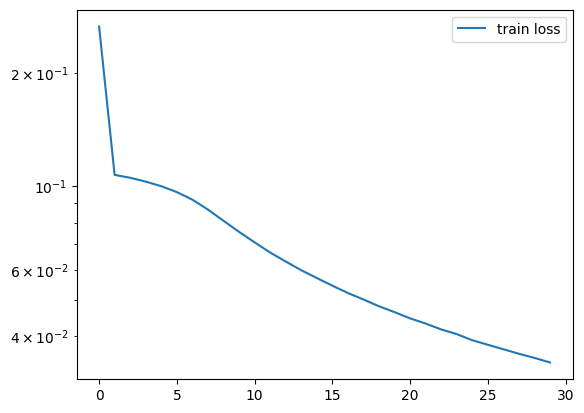

In [9]:
plt.plot(losses, label="train loss")
plt.yscale("log")
plt.legend()

C:\Users\bouet\AppData\Local\Temp\ipykernel_24844\3674773571.py:22: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  X_roll[i, offset_start:offset_end, :, :] = X[start:end, 0, :, :]


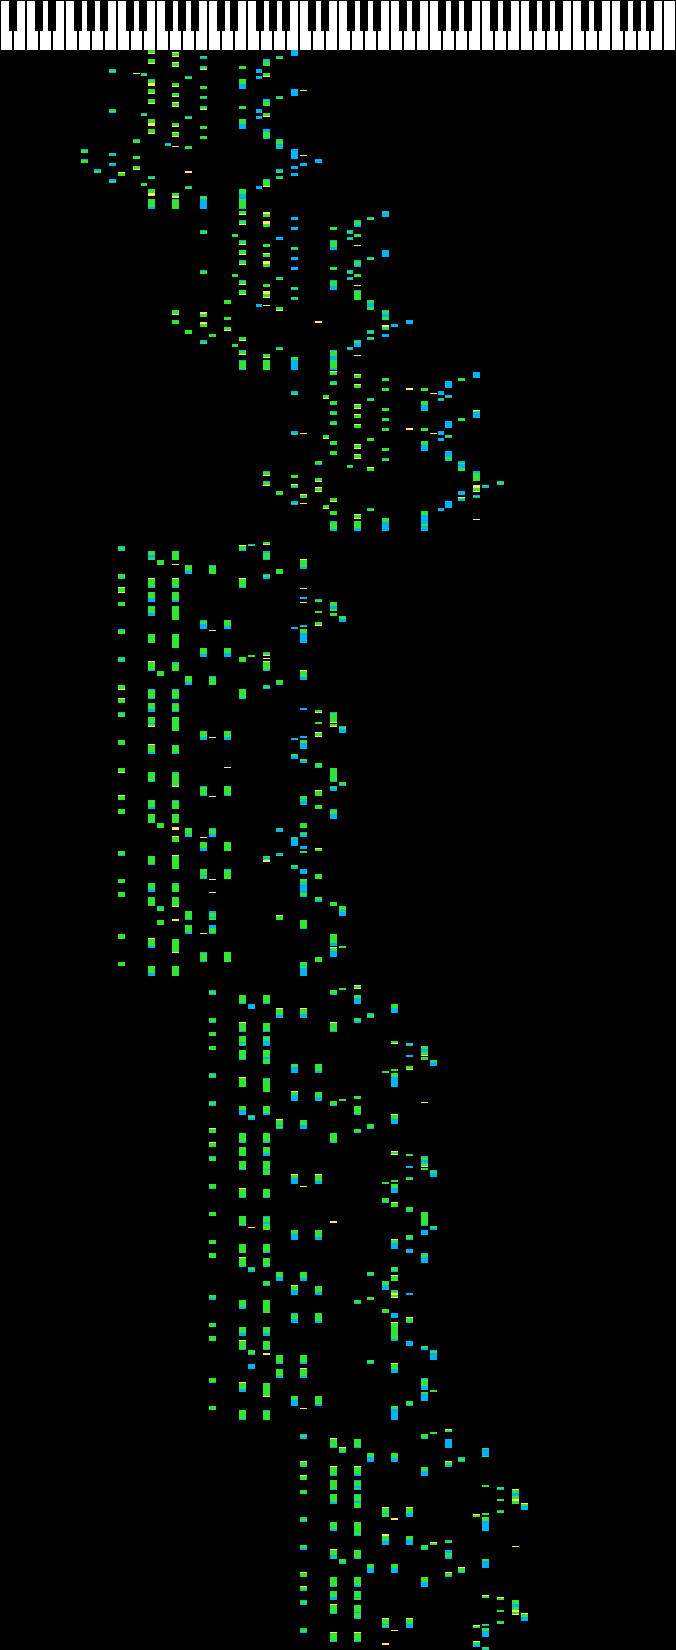

In [10]:
from scr.display import midis_comparison
midis_comparison(
    y_train.numpy(), (model.predict(X_train)>0.5).astype(int),
    target_color=(0, 0.7, 1), preds_color=(1, 0.9, 0.4), correct_color=(0.2, 0.9, 0.2),
    duration=200,
)

C:\Users\bouet\AppData\Local\Temp\ipykernel_24844\3674773571.py:22: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  X_roll[i, offset_start:offset_end, :, :] = X[start:end, 0, :, :]


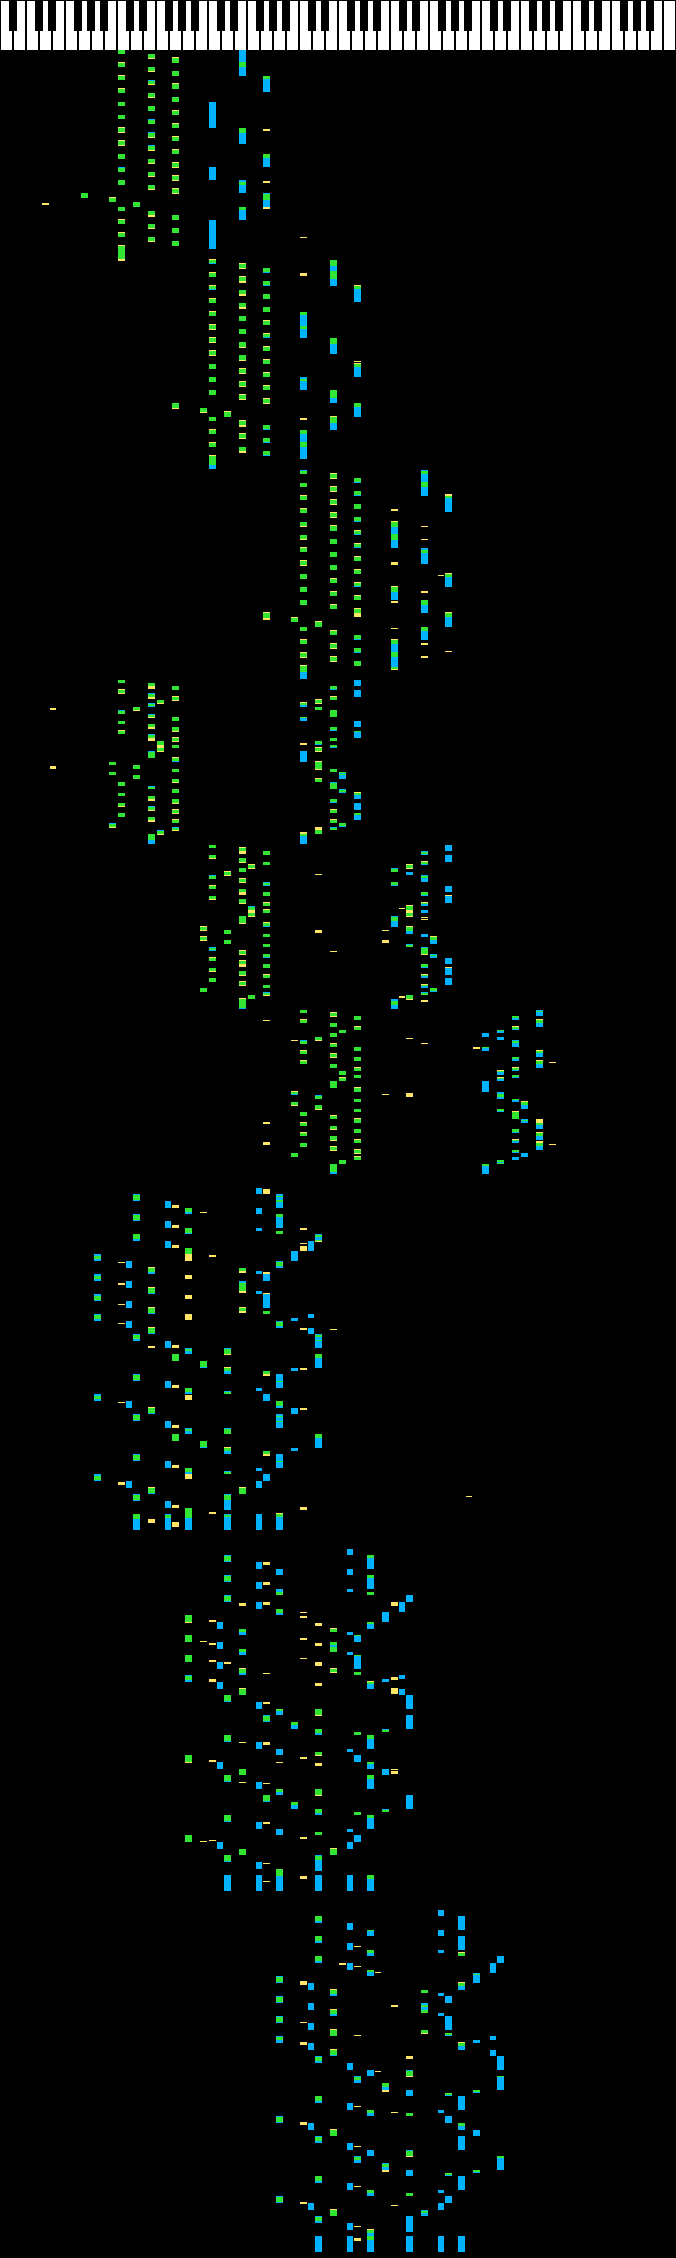

In [11]:
preds = (model.predict(X_test)>0.5).astype(int)

midis_comparison(
    y_test.numpy(), preds,
    target_color=(0, 0.7, 1), preds_color=(1, 0.9, 0.4), correct_color=(0.2, 0.9, 0.2)
)


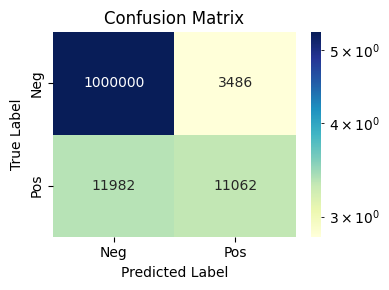

In [12]:
from sklearn.metrics import confusion_matrix
from matplotlib import colors
import seaborn as sns


cm = confusion_matrix(
    y_test.flatten(), preds.flatten()
)
cm_log = np.log(cm + 1) / np.log(10)
cm = (cm / np.max(cm) * 1000000).astype(int)
# Create figure and axes
plt.figure(figsize=(4, 3))

norm = colors.LogNorm(vmin=max(cm_log.min(), 1e-10), vmax=cm_log.max())

# Create heatmap with log scaling
sns.heatmap(cm_log, annot=cm, fmt='d', cmap='YlGnBu', 
            norm=norm,
            xticklabels=['Neg', 'Pos'],
            yticklabels=['Neg', 'Pos'])

# Add labels and title
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.tight_layout()